# Import Library

In [1]:
# Base
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from yellowbrick.classifier import ConfusionMatrix
from collections import  Counter

# Library Gensim
from gensim.models import FastText
from numpy.linalg import norm # untuk normalisasi nilai vektor

# Library Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout,Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Dataset

In [2]:
path = 'https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv'
data = pd.read_csv(path)
data.drop(columns=data.columns[0], axis=1, inplace=True)
data.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Exploratory Data Analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [4]:
data.shape

(24783, 6)

In [5]:
data.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


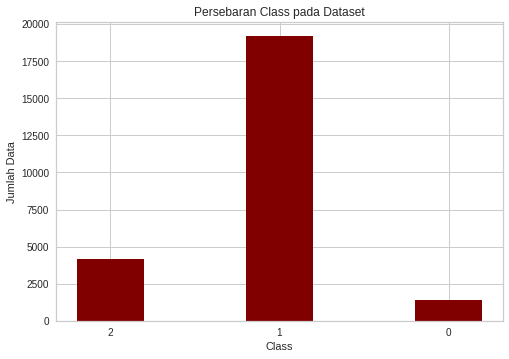

In [6]:
counts = []
for clas in data['class'].unique():
  counts.append(data[data['class'] == clas].shape[0])

x = [str(val) for val in data['class'].unique()]
plt.bar(x, counts, color ='maroon',
        width = 0.4)
 
plt.xlabel("Class")
plt.ylabel("Jumlah Data")
plt.title("Persebaran Class pada Dataset")
plt.show()

In [7]:
print('Jumlah Data Class 0:', len(data[data['class'] == 0]))
print('Jumlah Data Class 1:', len(data[data['class'] == 1]))
print('Jumlah Data Class 2:', len(data[data['class'] == 2]))

Jumlah Data Class 0: 1430
Jumlah Data Class 1: 19190
Jumlah Data Class 2: 4163


Jumlah data ketiga kelas bisa dikatakan tidak seimbang karena selisih antara jumlah ketiga kelas cukup besar.

### **Analisis Rata Rata Jumlah Kata dalam Kalimat Teks**

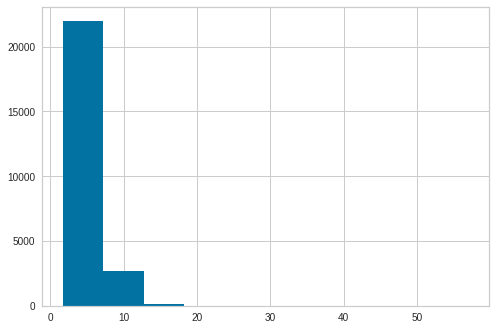

In [8]:
data['tweet'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

Jumlah kata yang digunakan pada kalimat review mulai dari 2 sampai 18 kata, dengan paling banyak 4 sampai 5 kata yang paling banyak digunakan.

### **Analisis stopword**

In [9]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

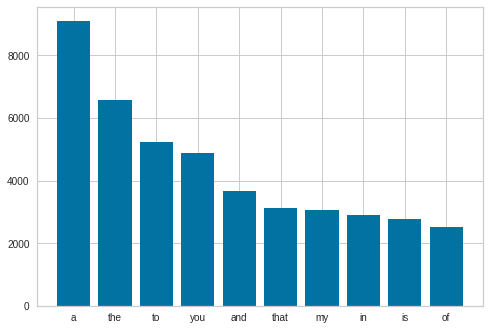

In [10]:
plot_top_stopwords_barchart(data['tweet'])

Terdapat cukup banyak stopword pada dataset. Stopword yang paling banyak muncul adalah kata 'a'.

### **Analisis non-stopword**

In [11]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english')+['rt'])
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word.lower() for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

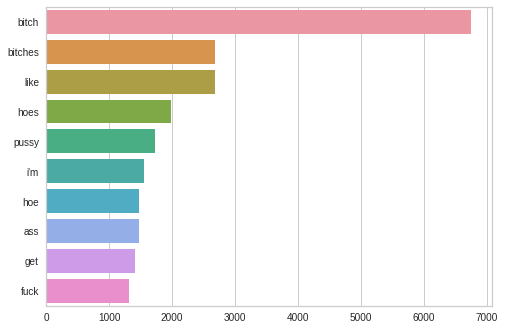

In [12]:
plot_top_non_stopwords_barchart(data['tweet'])

Kata non-stopword yang paling banyak muncul adalah kata 'b**ch'

### **Analisis n-gram**

In [13]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english')+['rt'])

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

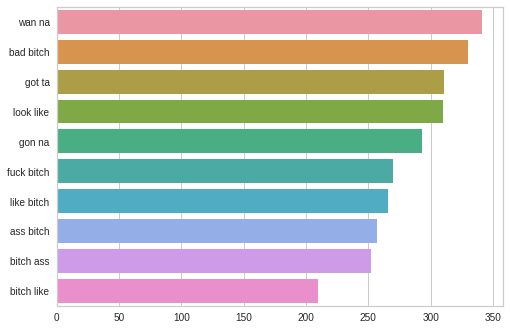

In [20]:
plot_top_ngrams_barchart(df.data['cleaned_text'],2)

Pada penerapan n-gram yakni 2-gram, kata 2-gram yang paling sering muncul adalah kata 'wan ra'. 

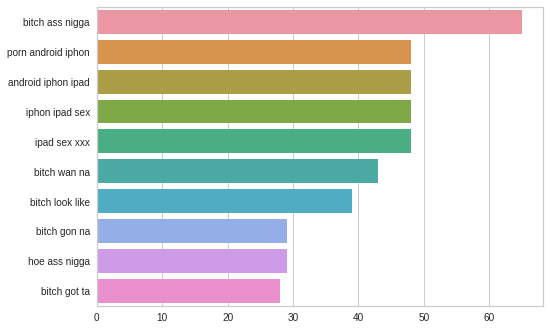

In [21]:
plot_top_ngrams_barchart(df.data['cleaned_text'],3)

Pada penerapan n-gram yakni 3-gram, kata 3-gram yang paling sering muncul adalah kata 'b\*\*ch a\*\* ni\*\*a '. 

# Preprocessing

In [15]:
class NLP:
  def __init__(self, data):
    self.data = data.copy()

  def simple_preprocessing(self, txt, remove_stopwords=True, tokenize=False, stemming=True):
    # lower the text
    text = txt.lower()

    # remove mentions
    text = text.replace(' rt ', '')
    text = re.sub(r'@[^ ]+', ' ', text)
    text = re.sub(r'&[^ ]+', ' ', text)
    
    # remove url
    text = re.sub(r'((www.\.[^\s]+)|(https?://[^\s]+))', '', text)

    # remove special characters
    text = re.sub(r'\W', ' ', text)

    # remove single character from the start
    text = re.sub(r'\^[A-Za-z]\s+', ' ', text)

    # remove number
    text = re.sub(r'[0-9]+', '', text)

    # remove prefixed 'b'
    text = re.sub(r'^b\s+', '', text)

    # remove single character
    text = re.sub(r'\s+[A-Za-z]\s+', ' ', text)
    
    # substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # remove stopwords
    if remove_stopwords:
      stopword = set(stopwords.words('english') + ['rt'])
      text = ' '.join([word for word in word_tokenize(text) if word not in stopword])

    if stemming:
      porter = PorterStemmer()
      text = ' '.join([porter.stem(word) for word in word_tokenize(text)])

    if tokenize:
      text = word_tokenize(text)

    return text

  def preprocess_df(self, column='tweet', remove_stopwords=True):
    self.data['cleaned_text'] = self.data[column].apply(self.simple_preprocessing)

  def preprocess_text(self, remove_stopwords=True, tokenize=False, stemming=False):
    self.data[0] = self.simple_preprocessing(self.data[0], remove_stopwords=remove_stopwords,
                                              tokenize=tokenize, stemming=stemming)

    if tokenize:
      self.data = list(np.array(self.data[0]).flatten())

In [16]:
df = NLP(data)
df.preprocess_df()
df.data.head()

,count,hate_speech,offensive_language,neither,class,tweet,cleaned_text
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman complain clean hous man alway take trash
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat cold tyga dwn bad cuffin dat hoe st place
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya


In [18]:
df1 = df.data[df.data['class'] == 0]
df2 = df.data[df.data['class'] == 1].iloc[:1430]
df3 = df.data[df.data['class'] == 2].iloc[:1430]

new_df = pd.concat([df1, df2, df3])

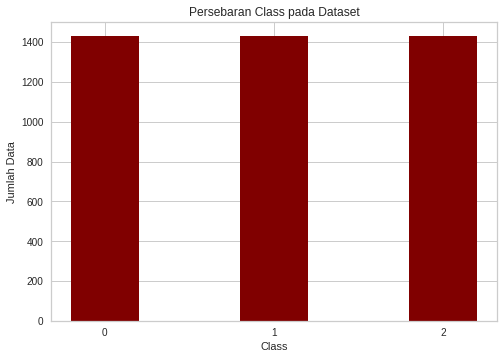

In [41]:
counts = []
for clas in new_df['class'].unique():
  counts.append(new_df[new_df['class'] == clas].shape[0])

x = [str(val) for val in new_df['class'].unique()]
plt.bar(x, counts, color ='maroon',
        width = 0.4)
 
plt.xlabel("Class")
plt.ylabel("Jumlah Data")
plt.title("Persebaran Class pada Dataset")
plt.show()

# Word Embedding dengan FASTTEXT

In [22]:
# membuat korpus
corpus = df.data['cleaned_text'].apply(lambda x: x.split())

In [23]:
# pembuatan model
model_fasttext = FastText(window=3, min_count=1, workers=4) # inisialisasi model FastText
model_fasttext.build_vocab(corpus) # membuat vocabulary
model_fasttext.train(corpus, total_examples=len(corpus), epochs=50) # training model terhadap dataset

In [24]:
model_fasttext.wv.most_similar('nigga')

[('niggaa', 0.9364062547683716),
 ('niggasupr', 0.934794008731842),
 ('niggad', 0.9228173494338989),
 ('errrnigga', 0.9188722372055054),
 ('niggga', 0.9169371128082275),
 ('niggar', 0.9075965881347656),
 ('niggaz', 0.9058934450149536),
 ('nigggga', 0.9047694802284241),
 ('niggass', 0.899651050567627),
 ('youmynigga', 0.8879954814910889)]

# MODEL LSTM

## LSTM

In [25]:
MAX_NB_WORDS = 50000

#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 100
weight_decay = 1e-4

In [26]:
y_final = new_df['class']
y_final = pd.get_dummies(y_final).values

In [27]:
X_final = new_df.drop(['class'], axis=1)
X_final['doc_len'] = X_final['tweet'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(X_final['doc_len'].mean() + X_final['doc_len'].std()).astype(int)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


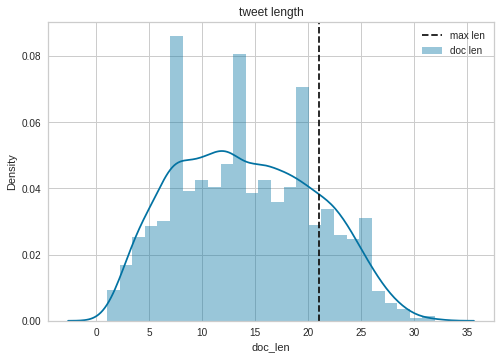

In [28]:
sns.distplot(X_final['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('tweet length'); plt.legend()
plt.show()

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=.33, random_state=42, shuffle=True)

In [30]:
print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(X_train['cleaned_text'].tolist())
word_seq_train = tokenizer.texts_to_sequences(X_train['cleaned_text'].tolist())
word_seq_test = tokenizer.texts_to_sequences(X_test['cleaned_text'].tolist())
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

tokenizing input data...
dictionary size:  5095


## Membangun Model LSTM dengan TENSORFLOW

In [31]:
word_vec = model_fasttext.wv
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
  if i >= nb_words:
      continue
  if word in word_vec:
    embedding_vector = word_vec[word]
  else:
    continue

  if (embedding_vector is not None) and len(embedding_vector) > 0:
      # words not found in embedding index will be all-zeros.
      embedding_matrix[i] = embedding_vector
  else:
      words_not_found.append(word)


model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3,activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 100)           509600    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               34048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 545,827
Trainable params: 36,227
Non-trainable params: 509,600
_____________________________________________

In [32]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=True)

Epoch 1/40
8/8 [==============================] - 6s 230ms/step - loss: 1.0732 - accuracy: 0.4137 - val_loss: 1.0361 - val_accuracy: 0.5203
Epoch 2/40
8/8 [==============================] - 1s 82ms/step - loss: 1.0078 - accuracy: 0.5346 - val_loss: 0.9686 - val_accuracy: 0.6222
Epoch 3/40
8/8 [==============================] - 1s 80ms/step - loss: 0.9282 - accuracy: 0.6171 - val_loss: 0.8897 - val_accuracy: 0.6477
Epoch 4/40
8/8 [==============================] - 1s 78ms/step - loss: 0.8342 - accuracy: 0.6743 - val_loss: 0.7993 - val_accuracy: 0.6929
Epoch 5/40
8/8 [==============================] - 1s 77ms/step - loss: 0.7507 - accuracy: 0.6997 - val_loss: 0.7075 - val_accuracy: 0.7196
Epoch 6/40
8/8 [==============================] - 1s 79ms/step - loss: 0.6750 - accuracy: 0.7369 - val_loss: 0.6421 - val_accuracy: 0.7462
Epoch 7/40
8/8 [==============================] - 1s 79ms/step - loss: 0.6050 - accuracy: 0.7688 - val_loss: 0.6100 - val_accuracy: 0.7625
Epoch 8/40
8/8 [==========

# Evaluasi

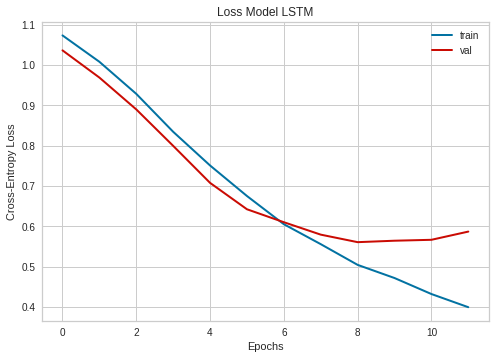

In [33]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Loss Model LSTM')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

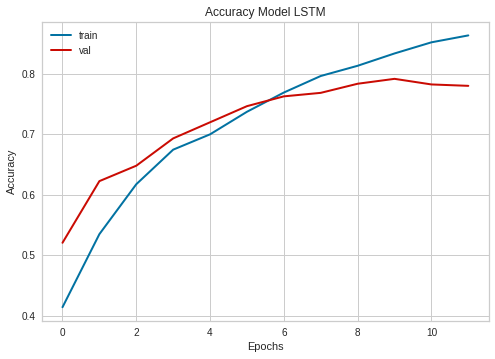

In [34]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('Accuracy Model LSTM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [43]:
sample_text = df.data['tweet'][1500]
seq = tokenizer.texts_to_sequences(sample_text)
padded = pad_sequences(seq, maxlen=max_seq_len)
pred = model.predict(padded)

print('Sample Text : ', sample_text)
print('Class : ', np.argmax(pred))


6/6 [==============================] - 0s 6ms/step
Sample Text :  &#8220;@RylannWilliams: @Woodchuck20 @ravenkiann Hahahaha do it bitch! Make her fall in love &#10084;&#10084;&#10084;&#10084;&#10084;&#10084;&#10084;&#8221; should I? &#128514;
Class :  2
